# Atelier utilisation d'EXIOBASE
Luxembourg Stratégie - février 2024

<thomas.gibon@list.lu>

## Introduction
(from [IO Models with Python](https://www.openriskacademy.com/course/view.php?id=64))

_What is an input-output model?_

Environmentally-extended multiregional input-output (EEMRIO) tables describe the economic relationships of economic actors (usually grouped or aggregated into industrial sectors) operating within geographic regions.

In addition to economic linkages, EEMRIO tables also aim to account for the environmental impacts of economic activity. To this end, an EEMRIO system complements the most basic (and historically the first introduced) economic input-output models with additional datasets and/or modelling assumptions, in order to provide insight into the environmental footprint of economic activity.

Currently, the focus on negative externalities of economic activity (e.g. human-induced climate change and biodiversity loss) makes EEMRIO models a useful conceptual and analytical tool. A good knowledge of the underlying input-output models is a prerequisite and will be the initial focus of this course.

_Definition_

An input-output model is an economic model constructed from observed (measured) economic data that provides information on the activity of industries that produce and consume goods and services. The central element of these models is the input-output matrix (or table). This matrix allows for a detailed analysis of the interdependent processes of production and use (consumption) of goods and services (products).

These models can trace both the material flows and the monetary income generated during these flows. Input-output tables can be presented in the form of:
- supply and use tables (SUTs) that relate products to industries or
- symmetric input-output tables that relate products to products or industries to industries.

**We will focus here on symmetric tables.**

## Installation

What you will need to use this notebook:

1. Anaconda (or Miniconda) distribution installation, which already contains all the basic Python modules for computations (numpy, pandas, ...), installation instructions are available [here](https://docs.anaconda.com/anaconda/install/index.html).

2. a `conda` environment dedicated to the project (not necessary, but recommended) by doing the following:
- open a terminal (`cmd` on Windows),
- create the environment in command line `conda create -n io`,
- activate the environment `activate io` or `conda activate io`

3. install `pymrio` from https://anaconda.org/conda-forge/pymrio
- in command line, make sure that the `io` environment is activated
- install the package `conda install -c conda-forge pymrio`

In [3]:
import pymrio as mr   # handling IO data
import pandas as pd   # handling datasets and tables
import numpy as np    # common math operations
import seaborn as sns # making figures, add-on to matplotlib
import matplotlib.pyplot as plt # making figures
import os # file system operations

In [4]:
# If you want to save/load precalculated data (faster)
import pickle

## Download EXIOBASE
The first thing to do is to retrieve the EXIOBASE input-output table(s), from the latest Zenodo repository.
Once the data is downloaded, import it, and you are ready to use it.

In [5]:
# URL of the database repository
doi = '10.5281/zenodo.5589597'

Pick the download repository

In [6]:
EXIOBASE_PATH = '../EXIOBASE/' # feel free to change

In [7]:
# The latest (relatively) reliable year is 2019
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

Start the download with the dedicated command.

Be careful, the database is large, if you have already downloaded once, there is no point in starting again.

In [9]:
if not os.path.isfile(filename):
    exio_meta = mr.download_exiobase3(
        storage_folder=EXIOBASE_PATH, # installation path
        system='ixi',                 # pick "product-by-product" (pxp) or "industry-by-industry" (ixi)
        years=year,                   # years to download
        doi=doi                       # repository URL
    )

Once the files are downloaded, all that remains is to import the `pymrio` database (the IO object).

In [10]:
io = mr.parse_exiobase3(path=filename)

Import the population data, interesting to produce the per-capita results.

In [11]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

Finally, the system must be "calculated" (solved), to determine, among other things, the environmental footprint results.

Indeed, the primary data of the system are intermediate consumption and final demand, as well as environmental impacts by sector.

To calculate a footprint we need coefficients, which is what `calc_all()` calculates. This is the subject of the next section.

In [12]:
io.calc_all()

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:935: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:935: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort

In [13]:
# Save
# with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'wb') as handle:
#     pickle.dump(io, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load
# with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'rb') as handle:
#     io = pickle.load(handle)

## Familiarization with the structure
The `io` object contains the entire structure of the multi-regional input-output table, i.e. the complete table of monetary coefficients/transactions between sectors and countries. These coefficients, once combined with the environmental extensions, will allow us to trace GHG emissions between production and consumption.

The diagram below shows how the data is organized. The nomenclature is not fixed, and unfortunately tends to change depending on the sources, here we will use:
- $Z$: intermediate consumption (`mrIot` in the figure), in M€/year,
- $Y$: final demand (`mrFinalDemand`), in M€/year,
- $F$: satellite accounts (`mrFactorInputs`), including environmental extensions (`mrEmissions`, `mrResources`, `mrMaterials`), in mixed units (M€, kg CO2, m$^{3}$, ... /year)
- $F_Y$: satellite accounts for final demand, only for environmental extensions (`mrFDEmissions`, `mrFDMaterials`), in mixed units.

<img src="https://exiobase.eu/images/mr_iot_v5_900px.png" width="600" height="240" style="margin-left:auto; margin-right:auto"/>

The elements derived from these source data are:
- $x$: total production of each sector, intermediate consumption and final demand, in M€/year, $x=Zi+Yi$, $i$ being a vector of "1" allowing to calculate the sum of the values ​​of the rows of a matrix when it is multiplied to the right,
- $A$: direct technical coefficients, in M€/M€, equivalent to $Z$, $A=Z\hat{x}^{-1}$,
- $S$: direct satellite coefficients, in mixed units/M€, equivalent to $F$, $S=F\hat{x}^{-1}$,
- $L$: "life cycle" technical coefficients (direct and indirect), in M€/M€, $L=(I-A)^{-1}$,
- $M$: satellite coefficients "in life cycle" (direct and indirect), in mixed units/M€, $M=SL=S(I-A)^{-1}$.

A coefficient $a_{ij}$ (respectively a transaction $z_{ij}$) always represents a transaction from sector i to sector j for a unit (respectively for a year). Any column vector therefore represents all the inputs for a given sector (like a cooking recipe gives the ingredients).

**All monetary matrices are organized in the same way, with an index (country, sector) for the rows and columns, in M€ or M€/M€. The matrices containing the emissions simply have a list of emissions in rows, and (country, sector) in columns.**

| Variable | Unit | Name in French | Name in English | Calculation | Example |
| --- | --- | --- | --- | --- | --- |
| $$x$$ | M€ | total output | $$x=Zi+Yi$$ | $x_i$ is the total production of sector $i$ |
| $$A$$ | M€/M€ | technology matrix | $$A=Z\hat{x}^{-1}$$ | $a_{ij}$ is the direct demand of sector $j$ for products of sector $i$ |
| $$S$$ | [M€,kg,m$^{3}$...]/M€ | stressor matrix | $$S=F\hat{x}^{-1}$$ | $s_{kj}$ represents the direct emissions of $k$ from sector $j$ |
| $$L$$ | M€/M€ | Leontief inverse | $$L=(I-A)^{-1}$$ | $l_{ij}$ is the total demand (direct and indirect) of sector $j$ for products of sector $i$ |
| $$M$$ | [M€,kg,m$^{3}$...]/M€ | multipliers | $$M=SL=F\hat{x}^{-1}(I-A)^{-1}$$ | $m_{kj}$ represents the total emissions (direct and indirect) of $k$ by sector $j$ |

### Countries and regions
EXIOBASE contains data from 49 geographic areas, including EU 27+1 at the beginning of the list and 5 "rest" areas (`W...`) at the end of the list (Asia, Latin America, Europe, Africa, world).

In [14]:
io.get_regions()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM'],
      dtype='object', name='region')

### Sectors
163 industrial sectors are available. The input-output tables therefore have a size of $(49 × 163) × (49 × 163) = 7987 × 7987$. Each element of the table gives us the value of annual transactions between one sector of one country, and another sector, of another country.

In [15]:
# Il faut utiliser "list" pour avoir la liste complète
list(io.get_sectors())[:20]

['Cultivation of paddy rice',
 'Cultivation of wheat',
 'Cultivation of cereal grains nec',
 'Cultivation of vegetables, fruit, nuts',
 'Cultivation of oil seeds',
 'Cultivation of sugar cane, sugar beet',
 'Cultivation of plant-based fibers',
 'Cultivation of crops nec',
 'Cattle farming',
 'Pigs farming',
 'Poultry farming',
 'Meat animals nec',
 'Animal products nec',
 'Raw milk',
 'Wool, silk-worm cocoons',
 'Manure treatment (conventional), storage and land application',
 'Manure treatment (biogas), storage and land application',
 'Forestry, logging and related service activities (02)',
 'Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)',
 'Mining of coal and lignite; extraction of peat (10)']

In [16]:
io.Z.shape

(7987, 7987)

### Z: intermediate consumption
This matrix contains the complete intermediate consumption between sectors, in M€ (in basic prices). It is a primary element (with final consumption) of the database, from which everything else is calculated.

The transactions contained in this matrix are compiled from the national accounts of each region.

In [17]:
io.Z.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                      0   
       Cultivation of wheat                                           0   
       Cultivation of cereal grains nec                               0   
       Cultivation of vegetables, fruit, nuts                         0   
       Cultivation of oil seeds                                       0   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                              12.533904   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                              12.825861   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                            0.000000   
       Cultivation of wheat                                                 0.000000   
       Cultivation of cereal grains nec                                     0.000000   
       Cultivation of vegetables, fruit, nuts                             113.553421   
       Cultivation of oil seeds                                             0.000000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                              0.000000   
       Cultivation of wheat                                   0.000000   
       Cultivation of cereal grains nec                       0.000000   
       Cultivation of vegetables, fruit, nuts                 0.000000   
       Cultivation of oil seeds                               0.532914   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [19]:
# The Luxembourg economy has suppliers from all over the world
# In monetary terms, what are the most important exchanges between sectors?

io.Z.loc[:,'LU'].stack().nlargest(40)

# Methods used here:
# .loc = indexation method, e.g. loc[row, col], loc[row_range, col_range]
# .stack() = expand columns into rows ("unpivots" a table)
# .nlargest(n) = returns the n largest values

region  sector                                                                                               sector                                                                                             
LU      Activities auxiliary to financial intermediation (67)                                                Financial intermediation, except insurance and pension funding (65)                                    33670.724335
        Financial intermediation, except insurance and pension funding (65)                                  Activities auxiliary to financial intermediation (67)                                                  22792.257543
                                                                                                             Financial intermediation, except insurance and pension funding (65)                                     9946.787027
        Post and telecommunications (64)                                                                     Compute

We note that in Luxembourg, the sectors with the highest consumption (in millions of euros) are financial intermediation, with all "support" activities, as well as communications and the business sector in general.

In [20]:
finance = ('LU','Financial intermediation, except insurance and pension funding (65)')

In [21]:
# Column sum
io.Z[finance].sum()

50697.323877110364

In total, this sector will have spent 50.7 billion euros, in Luxembourg and abroad. This is without taxes and other transportation/insurance costs (basic prices).

In [22]:
io.Z[('LU','Construction (45)')].nlargest(50)

region  sector                                                                                                                              
LU      Real estate activities (70)                                                                                                             818.452099
        Construction (45)                                                                                                                       186.178998
        Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)    108.981440
        Post and telecommunications (64)                                                                                                         92.341197
        Renting of machinery and equipment without operator and of personal and household goods (71)                                             58.226548
        Insurance and pension funding, except compulsory social security (66)       

In [31]:
io.Z[('LU','Construction (45)')].xs('Manufacture of fabricated metal products, except machinery and equipment (28)', level=1).nlargest(50)

region
DE    27.746928
NL    27.260541
WM    22.224568
FR    15.823765
WA    14.411050
IT     5.045030
SE     4.498292
PL     4.312887
DK     2.965840
GB     2.905556
ES     2.763851
US     2.637665
CH     2.365668
AT     1.852564
CZ     1.823412
IE     1.787509
WE     1.572053
TR     1.340892
PT     1.264281
IN     1.200441
RO     1.129611
SK     1.053863
WF     0.910211
HU     0.700214
LU     0.681792
HR     0.527178
LV     0.415557
JP     0.385923
BG     0.367191
EE     0.347793
AU     0.331215
CA     0.313217
FI     0.304248
GR     0.302370
SI     0.256197
KR     0.190477
BE     0.178490
NO     0.160531
RU     0.160386
LT     0.137122
ZA     0.116652
BR     0.111658
WL     0.103874
MT     0.095200
MX     0.078375
ID     0.034756
CY     0.002505
TW     0.000000
CN     0.000000
Name: (LU, Construction (45)), dtype: float64

In [27]:
io.Z[('LU','Construction (45)')].xs('Manufacture of cement, lime and plaster', level=1).nlargest(20)

region
IE    21.090272
DE    10.269122
NL     9.330624
FR     4.661992
WM     2.214372
WA     1.756409
ES     1.054016
PL     0.510067
GB     0.434141
LT     0.332825
AT     0.314911
IT     0.304374
DK     0.211563
WF     0.206812
HR     0.195962
PT     0.187260
HU     0.183032
CZ     0.137604
CH     0.105676
WE     0.084307
Name: (LU, Construction (45)), dtype: float64

### Y: final demand
Final demand contains information on final consumption of households, NGOs, and government, as well as inventory changes or capital consumption.

In [18]:
io.Y['LU'].columns

Index(['Final consumption expenditure by households',
       'Final consumption expenditure by non-profit organisations serving households (NPISH)',
       'Final consumption expenditure by government',
       'Gross fixed capital formation', 'Changes in inventories',
       'Changes in valuables', 'Exports: Total (fob)'],
      dtype='object', name='category')

For example, what are the main spending sectors of German households?

In [19]:
io.Y['LU','Final consumption expenditure by households'].nlargest(30)

region  sector                                                                                                             
LU      Insurance and pension funding, except compulsory social security (66)                                                  864.039476
WA      Chemicals nec                                                                                                          748.951601
DE      Manufacture of motor vehicles, trailers and semi-trailers (34)                                                         545.417359
BE      Hotels and restaurants (55)                                                                                            537.203594
FR      Manufacture of motor vehicles, trailers and semi-trailers (34)                                                         492.949513
NL      Processing of Food products nec                                                                                        396.500201
LU      Supporting and auxiliary transport activ

According to EXIOBASE, Luxembourg households spend mainly in the sectors of
- insurance (including private pensions),
- chemicals (broad category),
- private vehicles (German and French),
- HORECA,
- food,
- travel agencies...

### x: total output
The total output of the economy includes both intermediate consumption (what companies produce for themselves, the "B2B") and final consumption (the final products intended for consumers, the "B2C").

The total output $x$ is a vector, verifying the equation $Zi+Yi=x$, $i$ being a unit vector (composed only of 1) allowing to sum the values of each row of $Z$ and $Y$.

In [23]:
# We can check that the sum of each row in Z + Y equals each element of x 

np.allclose(io.Z.sum(axis=1) + io.Y.sum(axis=1),
            io.x['indout'])

# Methods
# .sum(axis=1) = calculate sum along axis 1 (columns)

True

In [24]:
io.x.loc[('LU','indout')].nlargest()

sector
Financial intermediation, except insurance and pension funding (65)                    63539.441461
Activities auxiliary to financial intermediation (67)                                  38810.596833
Other business activities (74)                                                         10701.717219
Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)     7573.986562
Construction (45)                                                                       7051.502808
Name: indout, dtype: float64

The sectors mentioned above are found to be the most important sectors of the Luxembourg economy. These values are equivalent to the "turnover" of each sector.

In [25]:
inputs = io.Z[finance].groupby('sector').sum().sort_values(ascending=False)
inputs.head(10)

sector
Activities auxiliary to financial intermediation (67)                                           34693.715604
Financial intermediation, except insurance and pension funding (65)                             14378.439688
Real estate activities (70)                                                                       438.504208
Insurance and pension funding, except compulsory social security (66)                             242.906799
Air transport (62)                                                                                226.671326
Renting of machinery and equipment without operator and of personal and household goods (71)      163.238995
Recreational, cultural and sporting activities (92)                                               108.392422
Distribution and trade of electricity                                                             104.128411
Manufacture of radio, television and communication equipment and apparatus (32)                    66.063732
Wholesale tr

In [26]:
threshold = 300
to_drop = inputs[inputs<threshold].index
inputs['REST'] = inputs[inputs<threshold].sum()
inputs = inputs.drop(to_drop)

In [28]:
io.x.loc[finance]

indout    63539.441461
Name: (LU, Financial intermediation, except insurance and pension funding (65)), dtype: float64

In [30]:
io.Z[finance].sum()

50697.323877110364

In [29]:
io.Z[finance].groupby('sector').sum().sort_values(ascending=False)

sector
Activities auxiliary to financial intermediation (67)                    3.469372e+04
Financial intermediation, except insurance and pension funding (65)      1.437844e+04
Real estate activities (70)                                              4.385042e+02
Insurance and pension funding, except compulsory social security (66)    2.429068e+02
Air transport (62)                                                       2.266713e+02
                                                                             ...     
Production of electricity by solar thermal                               9.184047e-09
Re-processing of secondary preciuos metals into new preciuos metals      1.039497e-11
Manure treatment (biogas), storage and land application                  0.000000e+00
Manure treatment (conventional), storage and land application            0.000000e+00
Extra-territorial organizations and bodies                               0.000000e+00
Name: (LU, Financial intermediation, except ins

63.5 billion euros were produced by this industry in 2019. The sector spent 50.7 billion euros the same year, mainly in financial services and equivalent, real estate, insurance, air transport, machine rental...

In [32]:
# Chart
input_output = pd.concat([inputs, pd.Series(dtype='float64')],axis=1,keys=['inputs','outputs'])
input_output.loc['output','outputs'] = io.x.loc[finance,'indout']

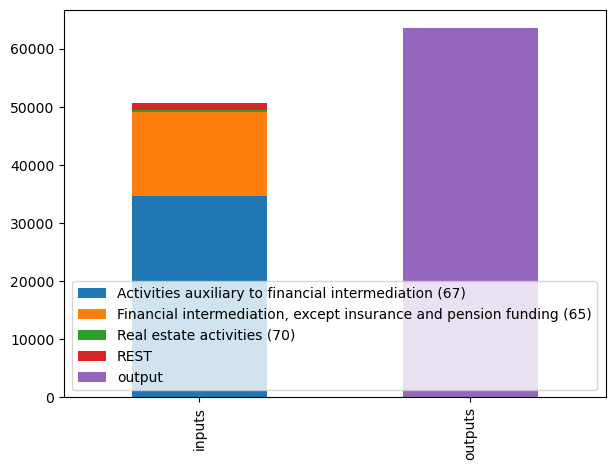

In [33]:
input_output.T.plot.bar(stacked=True).legend(loc='lower center')
plt.tight_layout()

In [34]:
# What is the difference between consumption and production in this sector?
io.x.loc[finance] - io.Z[finance].sum()

indout    12842.117584
Name: (LU, Financial intermediation, except insurance and pension funding (65)), dtype: float64

The difference between the two values, 12.8 billion euros, is equivalent to taxes, payroll, and profits.

These values are contained in the first (9) lines of the matrix of "satellite" accounts (considered external to the market economy), which is described below. For information, we find this difference here.

In [35]:
io.satellite.F[finance][:9].sum()

12842.1175958972

In [36]:
io.satellite.F[finance][:9]

stressor
Taxes less subsidies on products purchased: Total                                                 300.704341
Other net taxes on production                                                                     755.171567
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled         14.378997
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    1113.460326
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      2490.300813
Operating surplus: Consumption of fixed capital                                                   142.792375
Operating surplus: Rents on land                                                                    0.000000
Operating surplus: Royalties on resources                                                           0.000000
Operating surplus: Remaining net operating surplus                                               8025.309175
Name: (LU,

C:\Users\Gibon\AppData\Local\Temp\ipykernel_124788\481572507.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([input_output,
C:\Users\Gibon\AppData\Local\Temp\ipykernel_124788\481572507.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


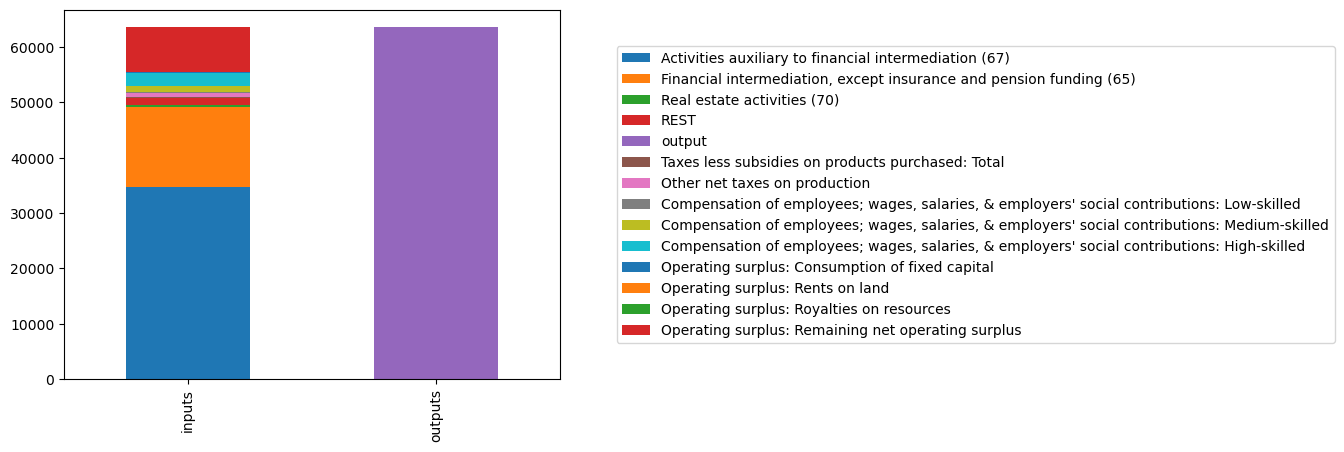

In [157]:
pd.concat([input_output,
           pd.concat([io.satellite.F[secteur_financier][:9],
                      pd.Series()],
                     axis=1,
                     keys=input_output.columns)],
          axis=0).T.plot.bar(stacked=True).legend(loc='lower center')

plt.legend(loc='center left', bbox_to_anchor=(1.1,0.5))

plt.tight_layout()

### A: coefficients de consommation intermédiaire
La matrice `A` contient les coefficients de consommation intermédiaire, en €/€.

Elle est calculée en "divisant" les transactions annuelles de $Z$ par la production totale $x$, formellement $A = Z\hat{x}^{-1}$.

In [158]:
# On peut vérifier que diviser Z par x donne bien la même chose que le contenu de A

io.Z.div(io.x['indout'], axis=1).head()

# a.div(b, axis=1) = division de a par b le long de l'axe 1 (colonnes)
# .head() = premières lignes (5) de la table

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                    NaN   
       Cultivation of wheat                                         NaN   
       Cultivation of cereal grains nec                             NaN   
       Cultivation of vegetables, fruit, nuts                       NaN   
       Cultivation of oil seeds                                     NaN   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                               0.033135   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                               0.014346   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                             0.00000   
       Cultivation of wheat                                                  0.00000   
       Cultivation of cereal grains nec                                      0.00000   
       Cultivation of vegetables, fruit, nuts                                0.06819   
       Cultivation of oil seeds                                              0.00000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                               0.00000   
       Cultivation of wheat                                    0.00000   
       Cultivation of cereal grains nec                        0.00000   
       Cultivation of vegetables, fruit, nuts                  0.00000   
       Cultivation of oil seeds                                0.00303   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [159]:
io.A.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                      0   
       Cultivation of wheat                                           0   
       Cultivation of cereal grains nec                               0   
       Cultivation of vegetables, fruit, nuts                         0   
       Cultivation of oil seeds                                       0   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                               0.033135   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                               0.014346   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                             0.00000   
       Cultivation of wheat                                                  0.00000   
       Cultivation of cereal grains nec                                      0.00000   
       Cultivation of vegetables, fruit, nuts                                0.06819   
       Cultivation of oil seeds                                              0.00000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                               0.00000   
       Cultivation of wheat                                    0.00000   
       Cultivation of cereal grains nec                        0.00000   
       Cultivation of vegetables, fruit, nuts                  0.00000   
       Cultivation of oil seeds                                0.00303   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

Quels sont les secteurs principaux composant les dépenses du secteur de l'électricité au charbon en Allemagne en 2019?

In [160]:
secteur_elec_charbon = ('DE','Production of electricity by coal')

In [161]:
io.A[secteur_elec_charbon].nlargest(10)

region  sector                                                                             
DE      Manufacture of gas; distribution of gaseous fuels through mains                        0.155498
        Mining of coal and lignite; extraction of peat (10)                                    0.148468
        Other land transport                                                                   0.029307
RU      Mining of coal and lignite; extraction of peat (10)                                    0.026134
DE      Construction (45)                                                                      0.023028
        Other business activities (74)                                                         0.019250
US      Mining of coal and lignite; extraction of peat (10)                                    0.018018
DE      Sea and coastal water transport                                                        0.017811
        Manufacture of electrical machinery and apparatus n.e.c. (31)       

Par euro d'électricité produite, le secteur de l'électricité au charbon en Allemagne dépense .16€ en gaz, .15€ en extraction de charbon allemand (.026€ et .018€ de charbon russe et américain respectivement), .029€ en transport, etc.

### Comptes satellites
Les matrices des comptes satellites sont les homologues de Z (et A), mais en termes de facteurs de production, de valeur ajoutée, et d'émissions de substances.

In [162]:
io.satellite.unit.iloc[20:].head(20)

,unit
Employment hours: High-skilled female,M.hr
Employment: Vulnerable employment,1000 p
Employment hours: Vulnerable employment,M.hr
CO2 - combustion - air,kg
CH4 - combustion - air,kg
N2O - combustion - air,kg
SOx - combustion - air,kg
NOx - combustion - air,kg
NH3 - combustion - air,kg
CO - combustion - air,kg


#### F: facteurs de production
Les facteurs de production sont simplement les "ressources primaires" (capital, emploi, ressources naturelles, émissions de substances). Cette matrice constitue l'interface entre l'économie et le reste de l'environnement.

On peut y trouver les informations sur les salaires, par exemple la masse salariale du secteur de la santé au Royaume-Uni se composait de 4.6/59/89 milliards d'euros en emplois non-qualifiés/intermédiaires/qualifiés en 2019.

In [163]:
io.satellite.F['GB','Health and social work (85)'].iloc[20:].head(20)

stressor
Employment hours: High-skilled female        3.014915e+03
Employment: Vulnerable employment            3.817769e+02
Employment hours: Vulnerable employment      6.654848e+02
CO2 - combustion - air                       2.330175e+09
CH4 - combustion - air                       1.981219e+06
N2O - combustion - air                       5.413355e+03
SOx - combustion - air                       5.375087e+05
NOx - combustion - air                       1.266915e+06
NH3 - combustion - air                       9.891829e+03
CO - combustion - air                        1.223304e+06
Benzo(a)pyrene - combustion - air            2.668940e+01
Benzo(b)fluoranthene - combustion - air      3.118305e+01
Benzo(k)fluoranthene - combustion - air      1.518335e+01
Indeno(1,2,3-cd)pyrene - combustion - air    1.793916e+01
PCBs - combustion - air                      0.000000e+00
PCDD_F - combustion - air                    1.570978e-05
HCB - combustion - air                       0.000000e+00
NMVOC

Ce secteur a par ailleurs émis 2.3 millions de tonnes de CO2 (en émissions directes dues à la combustion de carburants fossiles).

In [164]:
io.satellite.F['GB','Health and social work (85)'].loc['CO2 - combustion - air']

2330174931.5

#### S: coefficients satellites directs
La matrice `S` contient la même information que `F`, mais par M€ au lieu du total annuel.

Les coefficients satellites sont donc l'équivalent de la matrice `A` pour les facteurs de production. Par exemple, combien de CO2 a été émis pour fournir 1€ de services de santé au Royaume-Uni ?

In [165]:
io.satellite.S.loc['CO2 - combustion - air',('GB','Health and social work (85)')]

6924.79879166

Quels secteurs sont les plus émetteurs (en émissions directes) par € de production au Luxembourg ?

In [166]:
list(io.satellite.get_index())

['Taxes less subsidies on products purchased: Total',
 'Other net taxes on production',
 "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
 "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
 "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",
 'Operating surplus: Consumption of fixed capital',
 'Operating surplus: Rents on land',
 'Operating surplus: Royalties on resources',
 'Operating surplus: Remaining net operating surplus',
 'Employment: Low-skilled male',
 'Employment: Low-skilled female',
 'Employment: Medium-skilled male',
 'Employment: Medium-skilled female',
 'Employment: High-skilled male',
 'Employment: High-skilled female',
 'Employment hours: Low-skilled male',
 'Employment hours: Low-skilled female',
 'Employment hours: Medium-skilled male',
 'Employment hours: Medium-skilled female',
 'Employment hours: High-skilled male',
 'Employment ho

In [167]:
io.satellite.S.loc['CH4 - agriculture - air','LU'].nlargest(20)

sector
Cattle farming                                                                                         277272.719754
Raw milk                                                                                                53169.935464
Meat animals nec                                                                                        34436.254744
Pigs farming                                                                                             5994.137360
Poultry farming                                                                                             0.418164
Cultivation of paddy rice                                                                                   0.000000
Cultivation of wheat                                                                                        0.000000
Cultivation of cereal grains nec                                                                            0.000000
Cultivation of vegetables, fruit, nuts                   

Nous faisons face ici à quelques limites d'EXIOBASE: les secteurs dont la production est quasi-nulle (ici la production de laine et de soie, ou le transport maritime, inexistants au Luxembourg) se voient attribuer des coefficients directs artificiellement élevés. À cause des différents ajustements et corrections apportés à la table multirégionale via les étapes d'harmonisation, certains secteurs "récupèrent" quelques émissions alors même que leur production est quasiment nulle, ce qui mène à des facteurs très élevés par €.

In [168]:
# Ne gardons que les secteurs avec plus de 10 M€ de PIB
S_above_1 = io.satellite.S.loc[:,io.x['indout'] > 10]
S_above_1.loc['CO2 - combustion - air','LU'].nlargest()

sector
Cultivation of wheat                              1.176083e+07
Sea and coastal water transport                   9.069464e+06
Production of electricity by biomass and waste    2.054696e+06
Air transport (62)                                1.905992e+06
Cultivation of cereal grains nec                  1.802155e+06
Name: CO2 - combustion - air, dtype: float64

### Impacts environnementaux et scores associés

On retrouve l'équivalent des comptes satellites (facteurs de production et émissions de substances) agrégés en impacts environnementaux. Par exemple, les comptes satellites contiennent les émissions de CO2, CH4 ou N2O, alors que les impacts environnementaux sont exprimés en scores agrégés (kg CO2 eq.).

In [169]:
list(io.impacts.get_index())

['Value Added',
 'Employment',
 'Employment hour',
 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)',
 'Human toxicity (USEtox) | USEtox2008 | CTUh (Rosenbaum et al., 2008)',
 'Fresh water Ecotoxicity (USEtox) | USEtox2008 | CTUe (Rosenbaum et al., 2008)',
 'EPS | Damage Approach | EPS (Steen, 1999))',
 'Carcinogenic effects on humans (H.A) | ECOINDICATOR 99 (H.A) | Carcinogenic effects on humans (H.A)',
 'Respiratory effects on humans caused by organic substances (H.A) | ECOINDICATOR 99 (H.A) | Respiratory effects on humans caused by organic substances (H.A)',
 'Respiratory effects on humans caused by inorganic substances (H.A) | ECOINDICATOR 99 (H.A) | Respiratory effects on humans caused by inorganic substances (H.A)',
 'Damages to human health caused by climate change (H.A) | ECOINDICATOR 99 (H.A) | Damages to human health caused by climate change (H.A)',
 'Damage to Ecosystem Quality caused by ecotoxic emissions (H.A) | ECOINDICATOR 

#### F: facteurs de production

Les émissions de gaz à effet de serre du secteur de la santé britannique pour l'année 2019 sont d'environ 2.4 millions de t CO2 eq.

In [170]:
io.impacts.F['GB','Health and social work (85)'].head()

impact
Value Added                                                                                       1.918723e+05
Employment                                                                                        5.176351e+03
Employment hour                                                                                   8.938395e+09
GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)    2.381319e+09
Human toxicity (USEtox) | USEtox2008 | CTUh (Rosenbaum et al., 2008)                              3.530734e+00
Name: (GB, Health and social work (85)), dtype: float64

#### S: coefficients satellites directs
La matrice `S` contient la même information que `F`, mais par M€ au lieu du total annuel.

In [171]:
io.impacts.S.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)',('GB','Health and social work (85)')]

7076.78714477

Les émissions de gaz à effet de serre liées à 1M€ du secteur de la santé au UK s'élèvent à 7.1 t CO2 eq. (dont 6.9 t CO2).

## Calculs d'empreintes

Les matrices passées en revue ci-dessus contiennent des données "directes", mais tout l'intérêt du modèle entrées-sorties est de pouvoir retracer les chaînes de valeur de chaque produit ou chaque industrie, de manière systématique.

### L: l'inverse de Leontief
La matrice `L` (pour Leontief) contient la somme des facteurs économiques directs ET indirects liés aux échanges entre chaque secteur.

Alors que `A` contient les coefficients techniques directs, par exemple "0.4€ de gaz par 1€ d'électricité", `L` contient la demande en gaz liée à la fabrication du ciment pour l'infrastructure de la centrale, à la demande en énergie liée à l'extraction, le raffinage et le transport dudit gaz, etc. – par exemple "0.6€ de gaz par 1€ d'électricité".

In [172]:
# Coefficients techniques directs pour la production d'1€ d'électricité au gaz au Luxembourg
io.A['LU','Production of electricity by gas'].groupby('sector').sum().nlargest()

sector
Manufacture of machinery and equipment n.e.c. (29)                 0.271269
Manufacture of gas; distribution of gaseous fuels through mains    0.231512
Other business activities (74)                                     0.116283
Construction (45)                                                  0.035634
Manufacture of electrical machinery and apparatus n.e.c. (31)      0.025054
Name: (LU, Production of electricity by gas), dtype: float64

In [173]:
# Coefficients techniques complets (Leontief) pour la production d'1€ d'électricité au gaz au Luxembourg
io.L['LU','Production of electricity by gas'].groupby('sector').sum().nlargest()

sector
Production of electricity by gas                                                       1.003937
Manufacture of machinery and equipment n.e.c. (29)                                     0.338420
Other business activities (74)                                                         0.306267
Manufacture of gas; distribution of gaseous fuels through mains                        0.236327
Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)    0.095409
Name: (LU, Production of electricity by gas), dtype: float64

On constate que le secteur de l'électricité au gaz a besoin de .27€ de machines et équipement pour produire 1€, mais .34€ en cycle de vie (puisque d'autres procédés en amont en ont également besoin).

La matrice `L` est calculée en partant de l'équation-bilan $$Ax+y=x$$ où $Ax$ représente la demande "amont" de ressources à produire en plus de la demande finale $y$ à délivrer aux ménages et aux administrations. La somme des deux doit être égale à la production totale.

Nous voulons connaître $x$ en fonction d'une demande finale connue $y$.

En isolant $x$ on obtient $$y=x-Ax=Ix-Ax$$ ($I$ étant la matrice identité) que l'on peut réécrire $$(I-A)x=y$$ $$x=(I-A)^{-1}y$$
On note $L=(I-A)^{-1}$ la matrice qui permet de calculer x (la production totale) en fonction de y (la consommation finale). C'est $L$ qui permet de calculer les impacts d'une demande avec une approche cycle de vie.

### M: coefficients satellites et impacts en cycle de vie ("multipliers")
Une fois $L$ calculé, il est relativement simple de définir des facteurs similaires à ceux contenus dans $S$, mais avec l'approche cycle de vie.
$$M=SL$$

In [174]:
# Quels secteurs ont les émissions de CO2 les plus élevées sur leur cycle de vie, par M€ ? 
io.satellite.M.loc['CO2 - combustion - air',io.x['indout'] > 100].nlargest(10)

region  sector                                                                               
RU      Steam and hot water supply                                                               1.866595e+08
WL      Extraction, liquefaction, and regasification of other petroleum and gaseous materials    1.427096e+08
US      Steam and hot water supply                                                               9.955171e+07
WA      Extraction, liquefaction, and regasification of other petroleum and gaseous materials    9.915953e+07
        Steam and hot water supply                                                               8.677258e+07
BR      Production of electricity by petroleum and other oil derivatives                         7.977432e+07
ZA      Production of electricity by coal                                                        7.763825e+07
JP      Inland water transport                                                                   7.456287e+07
IT      Steam and hot wate

Les secteurs de l'énergie sont en général les plus émetteurs. Il faut noter que ces facteurs sont par M€ de production, donc ils dépendent des prix de chaque intrant et sont voués à plus varier que  

Arrêtons-nous là :)

In [183]:
sects = [
    'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)',
 'Re-processing of secondary wood material into new wood material',
 'Pulp',
 'Re-processing of secondary paper into new pulp',
 'Paper'
]

In [184]:
io.satellite.D_pba.loc['CO2 - combustion - air']['FI'][sects]

sector
Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)    5.320229e+07
Re-processing of secondary wood material into new wood material                                                                         0.000000e+00
Pulp                                                                                                                                    6.328733e+08
Re-processing of secondary paper into new pulp                                                                                          0.000000e+00
Paper                                                                                                                                   9.490038e+08
Name: CO2 - combustion - air, dtype: float64

In [185]:
io.satellite.D_cba.loc['CO2 - combustion - air']['FI'][sects]

sector
Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)    6.768951e+07
Re-processing of secondary wood material into new wood material                                                                         3.745958e+06
Pulp                                                                                                                                    3.704010e+07
Re-processing of secondary paper into new pulp                                                                                          7.098084e+05
Paper                                                                                                                                   3.243101e+08
Name: CO2 - combustion - air, dtype: float64

In [194]:
io.satellite.S.loc['CO2 - combustion - air'].mul(io.L, axis=0)['FI'][sects].sort_values(by=sects[-1], ascending=False)

sector                                                     Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)  \
region sector                                                                                                                                                                                     
FI     Paper                                                                                       44.096973                                                                                      
       Supporting and auxiliary transport activities; ...                                         765.009904                                                                                      
       Other land transport                                                                       428.531224                                                                                      
       Forestry, logging and related service activitie...                                        1915.059813                                                                                      
       Wholesale trade and commission trade, except of...                                         208.706596                                                                                      
...                                                                                                      ...                                                                                      
CN     Biogasification of paper, incl. land application                                             0.000000                                                                                      
       Biogasification of food waste, incl. land appli...                                           0.000000                                                                                      
       Re-processing of secondary construction materia...                                           0.000000                                                                                      
       Recycling of bottles by direct reuse                                                         0.000000                                                                                      
WM     Extra-territorial organizations and bodies                                                   0.000000                                                                                      

sector                                                     Re-processing of secondary wood material into new wood material  \
region sector                                                                                                                
FI     Paper                                                                                             0.0                 
       Supporting and auxiliary transport activities; ...                                                0.0                 
       Other land transport                                                                              0.0                 
       Forestry, logging and related service activitie...                                                0.0                 
       Wholesale trade and commission trade, except of...                                                0.0                 
...                                                                                                      ...                 
CN     Biogasification of paper, incl. land application                                                  0.0                 
       Biogasification of food waste, incl. land appli...                                                0.0                 
       Re-processing of secondary construction materia...                                                0.0                 
       Recycling of bottles by direct reuse                                   